# comparing linear to spline regression on the hippocampus enigma meshes

#### this notebook is to compare the R2 scores of linear and varying degrees of spline regression to test model fit, and AIC/BIC to assess goodness of fit vs model complexity. it generates various pandas dataframes which can be viewed as tables. my conclusions are that going more complex than linear is not worth it due to risk of overfitting (although this is only with the pilot subject of the study. more tests should be done when more data comes in)

In [3]:
import os
import numpy as np
import pyvista as pv
import nibabel
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import r2_score
import pandas as pd

from pathlib import Path

import numpy as np
import pyvista as pv
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

import polpo.preprocessing.pd as ppd
from polpo.models import ObjectRegressor
from polpo.preprocessing import (
    IndexMap,
    Map,
    NestingSwapper,
    PartiallyInitializedStep,
)
from polpo.preprocessing.dict import DictMap, DictMerger
from polpo.preprocessing.load.pregnancy import (
    DenseMaternalCsvDataLoader,
    DenseMaternalMeshLoader,
)
from polpo.preprocessing.mesh.conversion import ToVertices
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.sklearn.adapter import AdapterPipeline
from polpo.sklearn.mesh import BiMeshesToVertices
from polpo.sklearn.np import BiFlattenButFirst, FlattenButFirst

structure_key = {
    10: "Left-Thalamus-Proper",
    11: "Left-Caudate",
    12: "Left-Putamen",
    13: "Left-Pallidum",
    17: "Left-Hippocampus",
    18: "Left-Amygdala",
    26: "Left-Accumbens-area",
    49: "Right-Thalamus-Proper",
    50: "Right-Caudate",
    51: "Right-Putamen",
    52: "Right-Pallidum",
    53: "Right-Hippocampus",
    54: "Right-Amygdala",
    58: "Right-Accumbens-area"
}

shapes_dir = '/Users/sak/.herbrain/data/pregnancy/maternal_brain_project/pilot_engima_shape/derivatives/enigma_shape_hires_long'

def nibabel_to_pyvista(mesh):
    V = mesh[0]
    F = mesh[1]
    face_data = np.hstack(np.c_[np.full(len(F), 3), F]).astype(np.int64)
    return pv.PolyData(V, face_data)

df = pd.read_csv("/Users/sak/.herbrain/data/pregnancy/28Baby_Hormones.csv")
X = df["gestWeek"]

dataset_pipe = DictMerger() + NestingSwapper() + IndexMap(lambda x: np.array(x)[:, None], index=0)
X

0      -3.0
1      -0.5
2       1.0
3       1.5
4       2.0
5       3.0
6       9.0
7      12.0
8      14.0
9      15.0
10     17.0
11     19.0
12     22.0
13     24.0
14     27.0
15     29.0
16     31.0
17     33.0
18     36.0
19     43.0
20     46.0
21     49.0
22     51.0
23     68.0
24     93.0
25    162.0
26    162.0
Name: gestWeek, dtype: float64

In [4]:
from scipy.stats import f, combine_pvalues
from scipy import stats
from statsmodels.stats.multitest import multipletests

model_configs = [
    ("linear", None),
    ("spline", 1),  # linear spline
    ("spline", 2),  # quadratic spline
    ("spline", 3),  # cubic spline
    ("spline", 4),  # cubic spline
]


In [5]:
all_meshes = {}
for structure_id, structure_name in structure_key.items():
        print(f"\n=== Processing {structure_name} ({structure_id}) ===")
        brain_structure_filename = f"resliced_mesh_{structure_id}"
        mesh_paths = []

        for subdir in sorted(os.listdir(shapes_dir)):
            full_path = os.path.join(shapes_dir, subdir, brain_structure_filename)
            if os.path.exists(full_path):
                mesh_paths.append((subdir, full_path))

        aligned_meshes = {}
        reference_mesh = None

        for i_mesh, (name, path) in enumerate(mesh_paths):
            mesh = nibabel.freesurfer.read_geometry(path)
            pv_mesh = nibabel_to_pyvista(mesh) 
            if i_mesh == 0:
                reference_mesh = pv_mesh
                aligned_meshes[i_mesh] = pv_mesh
            else:
                aligned = pv_mesh.align(
                    reference_mesh,
                    max_landmarks=100,
                    max_mean_distance=1e-5,
                    max_iterations=500,
                    check_mean_distance=True,
                    start_by_matching_centroids=True,
                )
                aligned_meshes[i_mesh] = aligned
        all_meshes[structure_id] = aligned_meshes


=== Processing Left-Thalamus-Proper (10) ===

=== Processing Left-Caudate (11) ===

=== Processing Left-Putamen (12) ===

=== Processing Left-Pallidum (13) ===

=== Processing Left-Hippocampus (17) ===

=== Processing Left-Amygdala (18) ===

=== Processing Left-Accumbens-area (26) ===

=== Processing Right-Thalamus-Proper (49) ===

=== Processing Right-Caudate (50) ===

=== Processing Right-Putamen (51) ===

=== Processing Right-Pallidum (52) ===

=== Processing Right-Hippocampus (53) ===

=== Processing Right-Amygdala (54) ===

=== Processing Right-Accumbens-area (58) ===


In [6]:
def full_regression_analysis(structure_key, shapes_dir, X_base, dataset_pipe):
    model_dfs = {}

    for model_type, spline_degree in model_configs:
        model_key = f"{model_type}" if model_type == "linear" else f"{model_type}_d{spline_degree}"
        rows = []

        for structure_id, structure_name in structure_key.items():
            print(f"\n=== Processing {structure_name} ({structure_id}) ===")
            brain_structure_filename = f"resliced_mesh_{structure_id}"
            mesh_paths = []

            for subdir in sorted(os.listdir(shapes_dir)):
                full_path = os.path.join(shapes_dir, subdir, brain_structure_filename)
                if os.path.exists(full_path):
                    mesh_paths.append((subdir, full_path))

            aligned_meshes = {}
            reference_mesh = None

            for i_mesh, (name, path) in enumerate(mesh_paths):
                mesh = nibabel.freesurfer.read_geometry(path)
                pv_mesh = nibabel_to_pyvista(mesh)  # <- You must define this
                if i_mesh == 0:
                    reference_mesh = pv_mesh
                    aligned_meshes[i_mesh] = pv_mesh
                else:
                    aligned = pv_mesh.align(
                        reference_mesh,
                        max_landmarks=100,
                        max_mean_distance=1e-5,
                        max_iterations=500,
                        check_mean_distance=True,
                        start_by_matching_centroids=True,
                    )
                    aligned_meshes[i_mesh] = aligned

            pca = PCA(n_components=4)
            objs2y = AdapterPipeline([
                BiMeshesToVertices(index=0),
                FunctionTransformer(func=np.stack),
                BiFlattenButFirst(),
                StandardScaler(with_std=False),
                pca,
            ])

            X, meshes_ = dataset_pipe((X_base, aligned_meshes))

            if model_type == 'linear':
                model = ObjectRegressor(LinearRegression(), objs2y=objs2y)
            elif model_type == 'spline':
                spline_model = make_pipeline(
                    SplineTransformer(n_knots=4, degree=spline_degree, include_bias=False),
                    LinearRegression(fit_intercept=True)
                )
                model = ObjectRegressor(spline_model, objs2y=objs2y)


            model.fit(X, meshes_)
            y_true = objs2y.transform(meshes_)
            y_pred = objs2y.transform(model.predict(X))

            if model_type == "linear":
                X_transformed = X
                linreg = model["model"].regressor_
            else:
                X_transformed = model["model"].regressor_.steps[0][1].transform(X)
                linreg = model["model"].regressor_.steps[-1][1]

            n, p = X_transformed.shape
            X_design = np.column_stack([np.ones(n), X_transformed])
            XTX_inv = np.linalg.inv(X_design.T @ X_design)

            r2_global = r2_score(y_true, y_pred, multioutput="uniform_average")
            r2_per_output = r2_score(y_true, y_pred, multioutput="raw_values")

            stats_rows = []
            all_p_vals = []
            all_t_stats = []

            for i in range(y_true.shape[1]):
                y_i = y_true[:, i]
                y_pred_i = y_pred[:, i]
                residuals = y_i - y_pred_i
                mse = np.sum(residuals**2) / (n - p - 1)
                se = np.sqrt(np.diagonal(mse * XTX_inv))

                if linreg.coef_.ndim == 2:
                    coef_i = np.concatenate(([linreg.intercept_[i]], linreg.coef_[i]))
                else:
                    coef_i = np.concatenate(([linreg.intercept_], linreg.coef_))

                t_stats = coef_i / se
                p_vals = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n - p - 1))

                for j in range(len(coef_i)):
                    coef_type = "intercept" if j == 0 else "slope"
                    spline_type = spline_degree if model_type == "spline" else None
                    stats_rows.append({
                        "Structure": structure_name,
                        "Model Key": model_key,
                        "Spline Degree": spline_type,
                        "Side": "L" if "Left" in structure_name else "R",
                        "Output Dimension": i,
                        "Coefficient Index": j,
                        "Coefficient Type": coef_type,
                        "Coefficient": coef_i[j],
                        "Standard Error": se[j],
                        "t-Statistic": t_stats[j],
                        "p-Value": p_vals[j],
                        "R² Output": r2_per_output[i],
                        "R² Global": r2_global
                    })

                    all_p_vals.append(p_vals[j])
                    if coef_type == "slope":
                        all_t_stats.append(t_stats[j])

            from scipy.stats import combine_pvalues
            _, combined_p = combine_pvalues(all_p_vals, method='fisher')
            mean_abs_t = np.mean(np.abs(all_t_stats)) if all_t_stats else np.nan

            _, q_vals, _, _ = multipletests(all_p_vals, method="fdr_bh")

            for row, q in zip(stats_rows, q_vals):
                row["q-Value"] = q
                row["Combined p-Value"] = combined_p
                row["Mean |t| (slopes only)"] = mean_abs_t
                rows.append(row)

        model_dfs[model_key] = pd.DataFrame(rows)

    return model_dfs


In [7]:
model_dfs = full_regression_analysis(structure_key, shapes_dir, X, dataset_pipe)


=== Processing Left-Thalamus-Proper (10) ===

=== Processing Left-Caudate (11) ===

=== Processing Left-Putamen (12) ===

=== Processing Left-Pallidum (13) ===

=== Processing Left-Hippocampus (17) ===

=== Processing Left-Amygdala (18) ===

=== Processing Left-Accumbens-area (26) ===

=== Processing Right-Thalamus-Proper (49) ===

=== Processing Right-Caudate (50) ===

=== Processing Right-Putamen (51) ===

=== Processing Right-Pallidum (52) ===

=== Processing Right-Hippocampus (53) ===

=== Processing Right-Amygdala (54) ===

=== Processing Right-Accumbens-area (58) ===

=== Processing Left-Thalamus-Proper (10) ===

=== Processing Left-Caudate (11) ===

=== Processing Left-Putamen (12) ===

=== Processing Left-Pallidum (13) ===

=== Processing Left-Hippocampus (17) ===

=== Processing Left-Amygdala (18) ===

=== Processing Left-Accumbens-area (26) ===

=== Processing Right-Thalamus-Proper (49) ===

=== Processing Right-Caudate (50) ===

=== Processing Right-Putamen (51) ===

=== Pr

In [8]:
linear_df = model_dfs["linear"]
spline_d2_df = model_dfs["spline_d2"]

In [9]:
spline_d2_df

,Structure,Model Key,Spline Degree,Side,Output Dimension,Coefficient Index,Coefficient Type,Coefficient,Standard Error,t-Statistic,p-Value,R² Output,R² Global,q-Value,Combined p-Value,Mean |t| (slopes only)
0,Left-Thalamus-Proper,spline_d2,2,L,0,0,intercept,18.656793,57.314078,0.325519,0.747864,0.149888,0.260252,0.987591,0.998412,0.483365
1,Left-Thalamus-Proper,spline_d2,2,L,0,1,slope,-31.960540,52.702081,-0.606438,0.550431,0.149888,0.260252,0.987591,0.998412,0.483365
2,Left-Thalamus-Proper,spline_d2,2,L,0,2,slope,-15.248286,61.854721,-0.246518,0.807567,0.149888,0.260252,0.987591,0.998412,0.483365
3,Left-Thalamus-Proper,spline_d2,2,L,0,3,slope,-10.455193,48.081090,-0.217449,0.829862,0.149888,0.260252,0.987591,0.998412,0.483365
4,Left-Thalamus-Proper,spline_d2,2,L,0,4,slope,-53.701451,111.606831,-0.481166,0.635149,0.149888,0.260252,0.987591,0.998412,0.483365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Right-Accumbens-area,spline_d2,2,R,3,0,intercept,11.245664,17.246238,0.652065,0.521114,0.198284,0.292819,0.931316,0.998874,0.452438
276,Right-Accumbens-area,spline_d2,2,R,3,1,slope,-5.158267,15.858454,-0.325269,0.748050,0.198284,0.292819,0.931316,0.998874,0.452438
277,Right-Accumbens-area,spline_d2,2,R,3,2,slope,-15.507611,18.612552,-0.833180,0.413698,0.198284,0.292819,0.931316,0.998874,0.452438
278,Right-Accumbens-area,spline_d2,2,R,3,3,slope,-3.189250,14.467962,-0.220435,0.827565,0.198284,0.292819,0.931316,0.998874,0.452438


In [10]:
linear_df[linear_df['Structure'] == 'Left-Hippocampus']

,Structure,Model Key,Spline Degree,Side,Output Dimension,Coefficient Index,Coefficient Type,Coefficient,Standard Error,t-Statistic,p-Value,R² Output,R² Global,q-Value,Combined p-Value,Mean |t| (slopes only)
32,Left-Hippocampus,linear,None,L,0,0,intercept,0.714367,2.980058,0.239716,0.812505,0.005426,0.135578,0.812505,0.003687,1.755442
33,Left-Hippocampus,linear,None,L,0,1,slope,-0.019967,0.054067,-0.369297,0.715016,0.005426,0.135578,0.812505,0.003687,1.755442
34,Left-Hippocampus,linear,None,L,1,0,intercept,-1.114477,2.205633,-0.505287,0.617783,0.023664,0.135578,0.812505,0.003687,1.755442
35,Left-Hippocampus,linear,None,L,1,1,slope,0.031150,0.040017,0.778425,0.443624,0.023664,0.135578,0.709798,0.003687,1.755442
36,Left-Hippocampus,linear,None,L,2,0,intercept,3.662418,1.432298,2.557023,0.017009,0.382986,0.135578,0.068034,0.003687,1.755442
37,Left-Hippocampus,linear,None,L,2,1,slope,-0.102366,0.025986,-3.939252,0.000579,0.382986,0.135578,0.004632,0.003687,1.755442
38,Left-Hippocampus,linear,None,L,3,0,intercept,-1.810190,1.441347,-1.255902,0.220763,0.130236,0.135578,0.441525,0.003687,1.755442
39,Left-Hippocampus,linear,None,L,3,1,slope,0.050595,0.026150,1.934794,0.064408,0.130236,0.135578,0.171753,0.003687,1.755442


In [11]:
spline_d2_df[spline_d2_df['Structure'] == 'Left-Hippocampus']

,Structure,Model Key,Spline Degree,Side,Output Dimension,Coefficient Index,Coefficient Type,Coefficient,Standard Error,t-Statistic,p-Value,R² Output,R² Global,q-Value,Combined p-Value,Mean |t| (slopes only)
80,Left-Hippocampus,spline_d2,2,L,0,0,intercept,-25.500945,64.972923,-0.392486,0.698476,0.076497,0.319912,0.914881,0.470149,0.83039
81,Left-Hippocampus,spline_d2,2,L,0,1,slope,32.368906,59.744628,0.541788,0.593410,0.076497,0.319912,0.914881,0.470149,0.83039
82,Left-Hippocampus,spline_d2,2,L,0,2,slope,21.177135,70.120330,0.302011,0.765480,0.076497,0.319912,0.914881,0.470149,0.83039
83,Left-Hippocampus,spline_d2,2,L,0,3,slope,35.343453,54.506136,0.648431,0.523418,0.076497,0.319912,0.914881,0.470149,0.83039
84,Left-Hippocampus,spline_d2,2,L,0,4,slope,36.493632,126.520783,0.288440,0.775710,0.076497,0.319912,0.914881,0.470149,0.83039
85,Left-Hippocampus,spline_d2,2,L,1,0,intercept,-46.568159,37.944995,-1.227254,0.232698,0.435548,0.319912,0.553694,0.470149,0.83039
86,Left-Hippocampus,spline_d2,2,L,1,1,slope,8.064474,34.891605,0.231129,0.819350,0.435548,0.319912,0.914881,0.470149,0.83039
87,Left-Hippocampus,spline_d2,2,L,1,2,slope,60.385391,40.951144,1.474572,0.154495,0.435548,0.319912,0.553694,0.470149,0.83039
88,Left-Hippocampus,spline_d2,2,L,1,3,slope,38.072613,31.832261,1.196039,0.244414,0.435548,0.319912,0.553694,0.470149,0.83039
89,Left-Hippocampus,spline_d2,2,L,1,4,slope,87.463709,73.889710,1.183706,0.249162,0.435548,0.319912,0.553694,0.470149,0.83039


In [12]:
linear_df[linear_df['Structure'] == 'Right-Hippocampus']

,Structure,Model Key,Spline Degree,Side,Output Dimension,Coefficient Index,Coefficient Type,Coefficient,Standard Error,t-Statistic,p-Value,R² Output,R² Global,q-Value,Combined p-Value,Mean |t| (slopes only)
88,Right-Hippocampus,linear,None,R,0,0,intercept,-3.666547,3.919283,-0.935515,0.358472,0.076711,0.051084,0.716945,0.529292,0.924157
89,Right-Hippocampus,linear,None,R,0,1,slope,0.102481,0.071107,1.441218,0.161932,0.076711,0.051084,0.618496,0.529292,0.924157
90,Right-Hippocampus,linear,None,R,1,0,intercept,-0.343617,2.261686,-0.151930,0.880462,0.002187,0.051084,0.931416,0.529292,0.924157
91,Right-Hippocampus,linear,None,R,1,1,slope,0.009604,0.041034,0.234057,0.816847,0.002187,0.051084,0.931416,0.529292,0.924157
92,Right-Hippocampus,linear,None,R,2,0,intercept,-2.197527,1.793677,-1.225152,0.231936,0.124722,0.051084,0.618496,0.529292,0.924157
93,Right-Hippocampus,linear,None,R,2,1,slope,0.061422,0.032543,1.887422,0.070766,0.124722,0.051084,0.566129,0.529292,0.924157
94,Right-Hippocampus,linear,None,R,3,0,intercept,0.130734,1.503809,0.086935,0.931416,0.000717,0.051084,0.931416,0.529292,0.924157
95,Right-Hippocampus,linear,None,R,3,1,slope,-0.003654,0.027284,-0.133929,0.894531,0.000717,0.051084,0.931416,0.529292,0.924157


In [13]:
def compute_model_comparison_table(model_dfs):
    summary_rows = []

    for model_type, df in model_dfs.items():
        grouped = df.groupby("Structure")

        for structure_name, group in grouped:
            n_outputs = group["Output Dimension"].nunique()
            n_obs = group["R² Output"].count() // (2 * n_outputs)  # 2 coefficients per output
            r2_global = group["R² Global"].iloc[0]
            combined_p = group["Combined p-Value"].iloc[0]
            mean_abs_t = group["Mean |t| (slopes only)"].iloc[0]

            # Get only slope rows to count number of parameters
            slope_rows = group[group["Coefficient Type"] == "slope"]
            t_stats = slope_rows["t-Statistic"].values
            p = slope_rows["Coefficient Index"].nunique()
            k = p * n_outputs + n_outputs  # slopes + intercepts

            # Estimate RSS from t-stats and standard error
            residuals = (slope_rows["Standard Error"] * slope_rows["t-Statistic"]) ** 2
            rss = residuals.sum()

            aic = n_obs * np.log(rss / n_obs) + 2 * k
            bic = n_obs * np.log(rss / n_obs) + k * np.log(n_obs)

            summary_rows.append({
                "Structure": structure_name,
                "Model Type": model_type,
                "R² Global": r2_global,
                "Combined p-Value": combined_p,
                "Mean |t| (slopes only)": mean_abs_t,
                "AIC": aic,
                "BIC": bic
            })

    return pd.DataFrame(summary_rows)

In [14]:
summary_df = compute_model_comparison_table(model_dfs)

In [15]:
summary_df_sorted = summary_df.sort_values(by=["Structure", "Model Type"])
summary_df_sorted

,Structure,Model Type,R² Global,Combined p-Value,Mean |t| (slopes only),AIC,BIC
0,Left-Accumbens-area,linear,0.051904,0.444414,1.041911,9.950192,-6.049808
14,Left-Accumbens-area,spline_d1,0.195653,0.348352,0.870615,41.273456,20.363811
28,Left-Accumbens-area,spline_d2,0.270913,0.589056,0.818591,56.580798,30.443741
42,Left-Accumbens-area,spline_d3,0.287968,0.988437,0.557132,91.732890,70.099585
56,Left-Accumbens-area,spline_d4,0.317112,0.423465,0.858208,124.563405,99.324549
...,...,...,...,...,...,...,...
13,Right-Thalamus-Proper,linear,0.025042,0.881653,0.697389,10.319762,-5.680238
27,Right-Thalamus-Proper,spline_d1,0.172609,0.600290,0.820582,44.187183,23.277538
41,Right-Thalamus-Proper,spline_d2,0.263005,0.897098,0.658096,59.321749,33.184693
55,Right-Thalamus-Proper,spline_d3,0.278648,0.885989,0.565952,95.799445,74.166140


In [16]:
summary_df[summary_df['Structure'] == 'Left-Hippocampus']

,Structure,Model Type,R² Global,Combined p-Value,Mean |t| (slopes only),AIC,BIC
3,Left-Hippocampus,linear,0.135578,0.003687,1.755442,11.760002,-4.239998
17,Left-Hippocampus,spline_d1,0.244578,0.020733,1.158899,44.884276,23.974631
31,Left-Hippocampus,spline_d2,0.319912,0.470149,0.830390,59.356378,33.219322
45,Left-Hippocampus,spline_d3,0.333376,0.991530,0.523245,95.697195,74.063889
59,Left-Hippocampus,spline_d4,0.407454,0.004440,1.240242,131.885682,106.646826


In [17]:
for mesh in all_meshes[17].values():
    print(mesh.points)

[[152.92700195 135.26100159 110.47899628]
 [153.3809967  135.67399597 110.47299957]
 [152.83799744 133.84700012 111.01799774]
 ...
 [143.227005   149.87800598 147.43600464]
 [143.83399963 150.04100037 147.81900024]
 [143.47799683 149.33200073 147.977005  ]]
[[153.34418528 135.55223947 110.50787639]
 [153.6563154  136.118693   110.44491681]
 [153.33767114 133.89207766 111.15597023]
 ...
 [142.29753834 149.46184549 147.28191801]
 [142.94307687 149.71539078 147.61887048]
 [142.61518741 149.05949327 147.82080895]]
[[153.29270189 135.75314714 110.43838895]
 [153.63650901 136.30533653 110.52597923]
 [153.3928652  134.15769305 111.05703062]
 ...
 [142.38650037 149.96292819 147.00536964]
 [143.05188258 150.17221106 147.40300414]
 [142.74181092 149.58128454 147.54120227]]
[[153.38699385 134.48823652 110.96618804]
 [153.78443371 134.9660367  111.00671961]
 [152.87642023 132.71470968 111.73475754]
 ...
 [142.68239389 149.61754416 147.36381184]
 [143.25316078 149.717273   147.83954083]
 [142.98402

In [18]:
# weeks, meshes_ = dataset_pipe((X, aligned_meshes))
weeks = np.array(X)
weeks.shape

(27,)

In [19]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

weeks[:19]

array([-3. , -0.5,  1. ,  1.5,  2. ,  3. ,  9. , 12. , 14. , 15. , 17. ,
       19. , 22. , 24. , 27. , 29. , 31. , 33. , 36. ])

In [20]:
all_meshes[17].values()

dict_values([PolyData (0x154c17760)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.388e+02, 1.640e+02
  Y Bounds:   1.309e+02, 1.542e+02
  Z Bounds:   1.105e+02, 1.496e+02
  N Arrays:   0, PolyData (0x154c769e0)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.390e+02, 1.642e+02
  Y Bounds:   1.308e+02, 1.542e+02
  Z Bounds:   1.104e+02, 1.497e+02
  N Arrays:   0, PolyData (0x154c76680)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.388e+02, 1.643e+02
  Y Bounds:   1.307e+02, 1.544e+02
  Z Bounds:   1.104e+02, 1.498e+02
  N Arrays:   0, PolyData (0x154c76860)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.391e+02, 1.641e+02
  Y Bounds:   1.306e+02, 1.543e+02
  Z Bounds:   1.105e+02, 1.498e+02
  N Arrays:   0, PolyData (0x154c76a40)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.389e+02, 1.643e+02
  Y Bounds:   1.306e+02, 1.542e+02
  Z Bounds:   1.101e+02, 1.499e+02
  N Array

Global R2 0.998
Component 1: r = 0.905, p = 0.0000015, R² = 0.818, p = 0.0000015
Component 2: r = 0.284, p = 0.2868518, R² = 0.081, p = 0.2868518
Component 3: r = 0.297, p = 0.2631222, R² = 0.089, p = 0.2631222
Component 4: r = 0.105, p = 0.6996894, R² = 0.011, p = 0.6996894


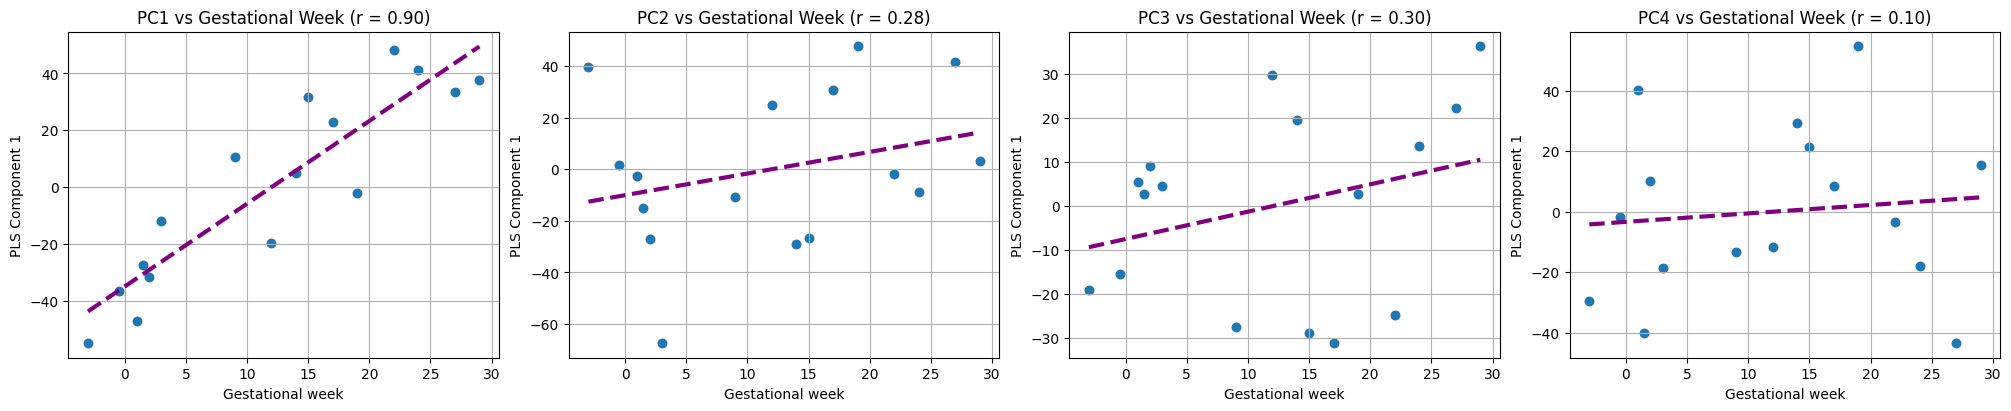

In [21]:
# for structure_id, structure_name in structure_key.items():
# figure, axs = plt.subplots(1, 4)
n_comps = 4
n_sessions = 16
fig, axes = plt.subplots(1, n_comps, figsize=(5 * n_comps, 4), constrained_layout=True)

for structure_id, structure_name in [(17,'Left-Hippocampus')]:
    aligned_meshes = all_meshes[structure_id]
    all_mesh_points = []
    for session_id in range(n_sessions): #mesh in aligned_meshes.values():
        mesh = aligned_meshes[session_id]
        all_mesh_points.append(mesh.points)
    weeks = weeks[0:n_sessions]
    # print(len(all_mesh_points[0]))
    # print(np.array(all_mesh_points).shape)
    # X, meshes_ = dataset_pipe((X_base, aligned_meshes))
    verts_reshaped = np.array(all_mesh_points).reshape(len(all_mesh_points), 3 * len(all_mesh_points[0]))
    X = StandardScaler().fit_transform(verts_reshaped)
    y = StandardScaler().fit_transform(weeks.reshape(-1,1))

    pls = PLSRegression(n_components=n_comps)
    pls.fit(X, y)

    pls_scores = pls.x_scores_
    r2_total = pls.score(X, y)
    print(f"Global R2 {r2_total:.3f}")

    for comp in range(n_comps):
        ax = axes[comp]
        corr, pval = pearsonr(pls_scores[:,comp], weeks)

        x_lr = weeks.reshape(-1, 1)
        # print("X LINREG",x_lr)
        y_lr = pls_scores[:, comp]
        reg = LinearRegression().fit(x_lr, y_lr)
        y_pred = reg.predict(x_lr)
        r2 = r2_score(y_lr, y_pred)
    
        print(f"Component {comp+1}: r = {corr:.3f}, p = {pval:.7f}, R² = {r2:.3f}, p = {pval:.7f}")
    
        ax.scatter(weeks, y_lr, label='Data', color='gray', alpha=0.6)
    
        # draw regression line
        x_pred = np.linspace(x_lr.min(), x_lr.max(), 100).reshape(-1, 1)
        y_line = reg.predict(x_pred)
        ax.plot(x_pred, y_line, color='purple', linestyle='--', label='Linear fit', linewidth=3)
    
        # print(f"Correlation between PC{comp+1} and gestational week: r = {corr:.3f}, p = {pval:.7f}")
        ax.scatter(weeks, pls_scores[:,comp])
        
        ax.set_xlabel("Gestational week")
        ax.set_ylabel("PLS Component 1")
        ax.set_title(f"PC{comp+1} vs Gestational Week (r = {corr:.2f})")
        ax.grid(True)
    plt.show()

In [25]:
import time
import logging
logging.getLogger().setLevel(logging.WARNING)

from scipy.spatial.distance import pdist

# function to try and play the animation in the jupyter notebook
def show_deformation_animation_notebook(
    mean_shape, direction, faces,
    alpha_max=30.0, n_frames=60, n_loops=3, comp_id=0,
    title="PLS Component Deformation"
):

    alphas = np.concatenate([
        np.linspace(-alpha_max, alpha_max, n_frames),
        np.linspace(alpha_max, -alpha_max, n_frames)
    ])

    mesh = pv.PolyData(mean_shape.copy(), faces)
    displacement = np.linalg.norm(direction, axis=1)
    mesh["Displacement"] = displacement

    plotter = pv.Plotter(notebook=True, window_size=(600, 600))
    # plotter.show(jupyter_backend='trame', auto_close=False)
    plotter.add_mesh(mesh, scalars="Displacement", cmap="viridis")
    plotter.add_text(f"PLS Component {comp_id + 1} | α = 0.00", position="upper_edge", font_size=10)
    plotter.show(auto_close=False)

    for loop in range(n_loops):
        for alpha in alphas:
            new_points = mean_shape + alpha * direction
            mesh.points = new_points.reshape(-1, 3)

            displacement = np.linalg.norm(alpha * direction, axis=1)
            mesh["Displacement"] = displacement

            plotter.render()
            time.sleep(0.03) 

    plotter.close()

# function to save the animation to a gif instead
def show_deformation_animation_save_gif(
    mean_shape, direction, faces,
    alpha_max=3.0, n_frames=60, comp_id=0,
    gif_path="_images/deformation.gif", title="PLS Component Deformation"
):
    alphas = np.linspace(-alpha_max, alpha_max, n_frames)

    mesh = pv.PolyData(mean_shape.copy(), faces)

    plotter = pv.Plotter(window_size=(800, 800))
    plotter.open_gif(gif_path)
    plotter.add_mesh(mesh, color='lightgray')
    plotter.reset_camera()

    for alpha in alphas:
        new_points = mean_shape + alpha * direction
        mesh.points = new_points.reshape(-1, 3)
        plotter.add_title(f"PLS Component {comp_id + 1} | α = {alpha:.2f}",font_size=12)
        plotter.reset_camera()
        plotter.write_frame() 
        plotter.render()

    plotter.close()

# function to show the deformations like the way Luis did in one of his how-to or notebooks ;)
def show_deformation_animation(mean_shape, direction, faces, alpha_max=30.0, n_frames=60, comp_id=0, title="PLS Component Deformation"):

    alphas = np.linspace(-alpha_max, alpha_max, n_frames)

    mesh = pv.PolyData(mean_shape.copy(), faces)

    plotter = pv.Plotter(window_size=(800, 800))
    plotter.add_mesh(mesh, color='lightgray')
    # plotter.add_mesh(mesh, scalars='Displacement', cmap='viridis')
    text_id = plotter.add_text("", position="upper_edge", font_size=12)
    plotter.show(auto_close=False)

    for alpha in alphas:
        new_points = mean_shape + alpha * direction
        mesh.points = new_points.reshape(-1, 3)  # update mesh geometry
        # displacement = np.linalg.norm(alpha * direction, axis=1)
        # mesh['Displacement'] = displacement
        plotter.add_title(f"PLS Component {comp_id + 1} | alpha = {alpha:.2f}",font_size=12)
        plotter.render()
        time.sleep(0.05)

    plotter.close()

# test my visualization functions -- for some reason the one to show the animation in the notebook isn't working anymore. it just says 'loading widget' forever
for structure_id, structure_name in [(17,'Left-Hippocampus')]:
    first_mesh = all_meshes[structure_id][0]

    points = mesh.points
    
    faces = first_mesh.faces

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(verts_reshaped)
    
    mean_shape = scaler.mean_
    weights = pls.x_weights_  # shape: (n_features, n_components)
    
    comp_id = 0  
    alpha = 3 
    
    direction = weights[:, comp_id]  # shape (n_vertices * 3,)
    
    # mean plus or minus alpha * component
    shape_plus = mean_shape + alpha * direction
    shape_minus = mean_shape - alpha * direction
    
    shape_mean = mean_shape.reshape(-1, 3)
    shape_plus = shape_plus.reshape(-1, 3)
    shape_minus = shape_minus.reshape(-1, 3)
        
    show_deformation_animation_save_gif(mean_shape.reshape(-1, 3), direction.reshape(-1, 3), faces, comp_id=0)
    # show_deformation_animation(mean_shape.reshape(-1, 3), direction.reshape(-1, 3), faces, comp_id=0)
    # show_deformation_animation_notebook(mean_shape.reshape(-1, 3), direction.reshape(-1, 3), faces, comp_id=0, n_loops=2)

In [26]:
import pyvista as pv
import numpy as np
from ipywidgets import interact, IntSlider

# function to show the alpha displacement through a slider
def interactive_pls_slider(
    mean_shape, direction, faces,
    alpha_max=30.0, n_frames=60, comp_id=0
):
    alphas = np.linspace(-alpha_max, alpha_max, n_frames)
    meshes = []

    max_disp = np.max(np.linalg.norm(alpha_max * direction, axis=1))
    scalar_range = (-max_disp, max_disp)

    # precompute all deformed meshes
    for alpha in alphas:
        deformed = mean_shape + alpha * direction
        deformed = deformed.reshape(-1, 3)
        # displacement = np.linalg.norm(alpha * direction, axis=1)
        displacement = np.dot(direction, np.ones(3)) * alpha  # signed magnitude
        mesh = pv.PolyData(deformed, faces)
        mesh["Displacement"] = displacement
        meshes.append(mesh)

    # Create a plotter for Jupyter
    plotter = pv.Plotter(notebook=True)
    # Add mesh with fixed colormap range
    actor = plotter.add_mesh(
        meshes[0],
        scalars="Displacement",
        cmap="coolwarm",
        clim=scalar_range
    )
    plotter.add_title(f"PLS Component {comp_id + 1} | alpha = {alphas[0]:.2f}", font_size=10)
    plotter.show(auto_close=False)

    def update(frame_idx):
        mesh = meshes[frame_idx]
        actor.mapper.SetInputData(mesh)
        plotter.add_title(f"PLS Component {comp_id + 1} | alpha = {alphas[frame_idx]:.2f}", font_size=10)
        plotter.render()

    interact(update, frame_idx=IntSlider(min=0, max=n_frames - 1, step=1, value=0))


interactive_pls_slider(mean_shape.reshape(-1, 3), direction.reshape(-1, 3), faces, comp_id=0)


interactive(children=(IntSlider(value=0, description='frame_idx', max=59), Output()), _dom_classes=('widget-in…